In [1]:
# Scripts for the analyses of the EEG data (active task only) collected at the Wellington Hospital - Aloi Davide PhD UoB
# Updated in May 2022

In [2]:
import numpy as np
import mne, os, glob
mne.set_log_level("WARNING")

# Let us define the folders to the EEG active task data
output_folder = 'D:\\Raindrop_eeg_analysis\\p01\\'
f_w1_b = 'D:\\Raindrop_data\\p01\\p01_w01\\eeg_baseline\\active_task\\' # folder baseline w 1
f_w2_p = 'D:\\Raindrop_data\\p01\\p01_w02\\day04_eeg\\active_task\\' # folder post w 2
f_w3_b = 'D:\\Raindrop_data\\p01\\p01_w03\\eeg_baseline\\active_task\\' # folder baseline w 3
f_w4_p = 'D:\\Raindrop_data\\p01\\p01_w04\\day04_eeg\\active_task\\' # folder post w 4

# Path to EEG mff files (I use regex as the name of the files include the date)
raw_w1_b = glob.glob(f_w1_b + '\*.mff')[0]
raw_w2_p = glob.glob(f_w2_p + '\*.mff')[0]
raw_w3_b = glob.glob(f_w3_b + '\*.mff')[0]
raw_w4_p = glob.glob(f_w4_p + '\*.mff')[0]

In [3]:
eegbin = np.fromfile(glob.glob(raw_w2_p + '\\signal1.bin')[0])
(eegbin.shape[0]/130)/1000

287.0697692307692

In [4]:
# Info about the EEG recording
raw = mne.io.read_raw_egi(raw_w3_b, preload=True)
print(raw.info) 

<Info | 10 non-empty values
 bads: []
 ch_names: E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, ...
 chs: 129 EEG, 3 Stimulus
 custom_ref_applied: False
 device_info: 1 item (dict)
 dig: 133 items (3 Cardinal, 130 EEG)
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2021-11-11 11:27:44 UTC
 nchan: 132
 projs: []
 sfreq: 1000.0 Hz
 utc_offset: +0000
>


In [6]:
picks_eeg = mne.pick_types(raw.info, meg=False, eeg=True, stim=False,
                       exclude='bads')
picks_stim = mne.pick_types(raw.info, meg=False, eeg=False, stim=True,
                       exclude='bads')

In [7]:
raw.get_data(picks=picks_stim)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

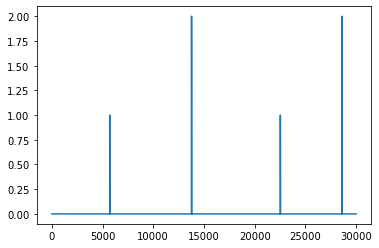

In [8]:
import matplotlib.pyplot as plt 
plt.plot(raw.get_data(picks=picks_stim)[2, 0:30000])

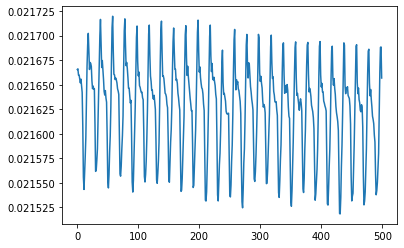

In [9]:
plt.plot(raw.get_data(picks=['E125', 'E126', 'E128', 'E129'])[1, 0:500])

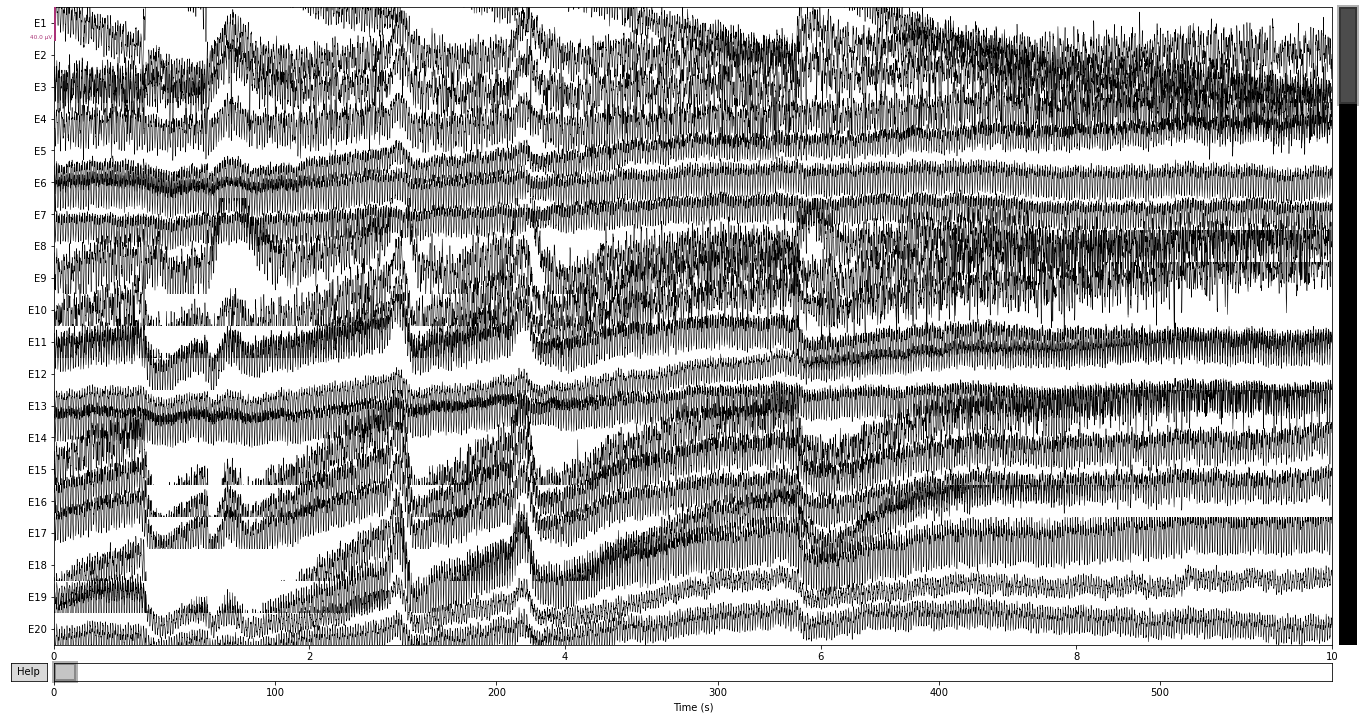

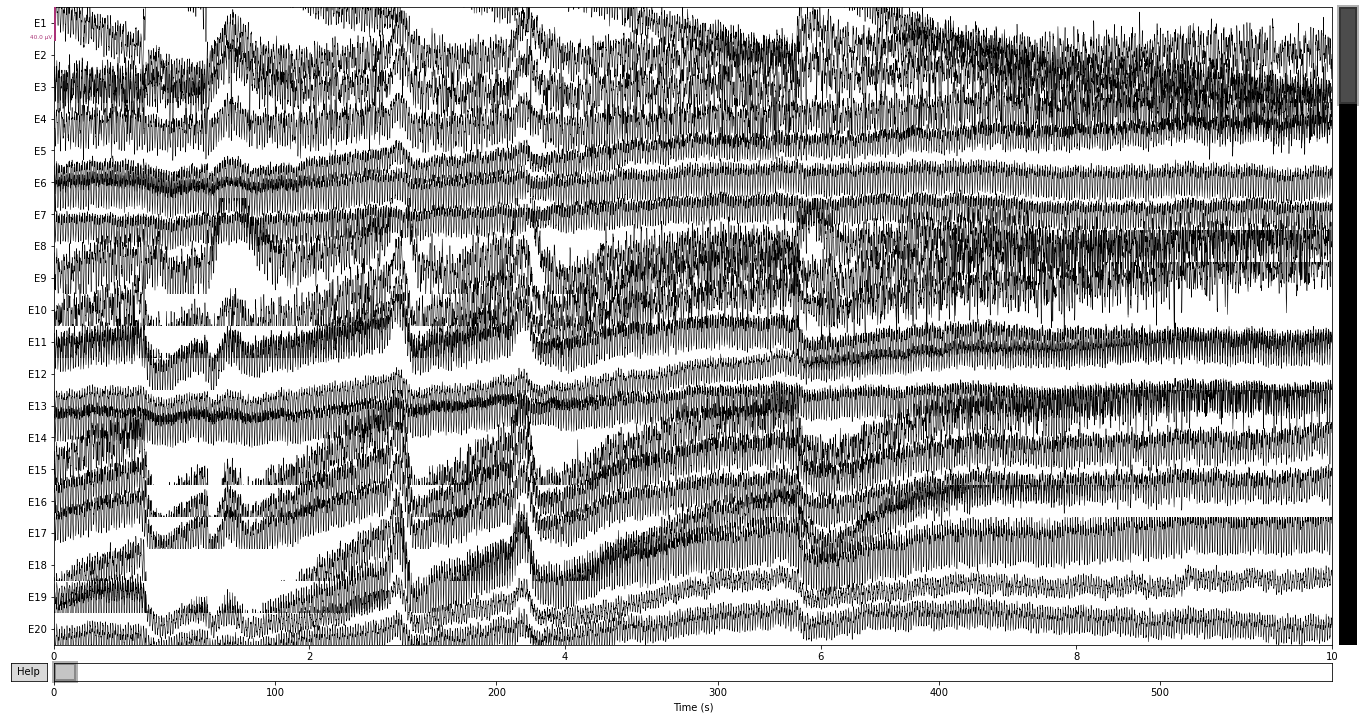

In [10]:
raw.plot()